<a href="https://colab.research.google.com/github/rlaaudrb1104/Ai/blob/PJH/GraphCoderBert_Feature_Juliet_25000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
!pip install accelerate -U
!pip install transformers[torch] -U
!pip install shap
!pip install dataset

In [23]:
!pip install datasets -U

In [24]:
import pandas as pd
import re

# 데이터셋 로드
df = pd.read_csv('/content/drive/MyDrive/data/MSR+julite+Div_final_train(2500cut_plus_alpha_feature).csv')

In [25]:
columns_to_drop = ['CWE ID', 'vul', 'lang']
df = df.drop(columns=columns_to_drop)

In [26]:
# 피쳐를 포함한 열의 범위 설정
feature_columns = df.columns[2:]  # 'chmod()'부터 마지막 열까지 피쳐

In [27]:
df.columns

Index(['code', 'labels', 'chmod()', 'assert()', 'atoi()', 'atof()', 'calloc()',
       'errno()', 'exit()', 'fclose()',
       ...
       'array_index_vulnerability', 'int', 'short', 'long', 'long long',
       'unsigned int', 'unsigned short', 'unsigned long', 'unsigned long long',
       'line_count'],
      dtype='object', length=102)

In [28]:
df.head(50)

,code,labels,chmod(),assert(),atoi(),atof(),calloc(),errno(),exit(),fclose(),...,array_index_vulnerability,int,short,long,long long,unsigned int,unsigned short,unsigned long,unsigned long long,line_count
0,void func() { int data; data = 0; { #ifdef ...,7,0,0,1,0,0,0,0,0,...,0,6,0,0,0,0,0,0,0,1
1,void func() { int data; int dataArray[5]; d...,7,0,0,1,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,1
2,void func() { unsigned int data; data = 0; ...,7,0,0,0,0,0,0,0,0,...,0,3,0,0,0,3,0,0,0,1
3,void func() { int data; int dataArray[5]; d...,7,0,0,1,0,0,0,0,0,...,0,4,0,0,0,0,0,0,0,1
4,void func() { unsigned int data; data = 0; ...,7,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
5,void func() { int data; data = 0; { char i...,7,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
6,void func() { int data; data = 0; { #ifdef ...,7,0,0,1,0,0,0,0,0,...,0,3,0,0,0,0,0,0,0,1
7,void func() { int64_t data; data = 0LL; fsc...,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,void func() { int data; data = 0; { char i...,7,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
9,void func() { int data; CWE190_Integer_Overf...,7,0,0,1,0,0,0,0,0,...,0,5,0,0,0,0,0,0,0,1


In [29]:
import gensim
import transformers
from gensim.models import Word2Vec
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from pandas.core.common import random_state
import numpy as np
from datasets import load_metric
from transformers import TrainingArguments, Trainer
import logging
import sklearn.metrics as metric
from transformers import DataCollatorWithPadding
import torch, gc
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss
from transformers import AdamW
from transformers import RobertaForSequenceClassification
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [30]:
from transformers import RobertaForSequenceClassification, AutoTokenizer

model = RobertaForSequenceClassification.from_pretrained("/content/drive/MyDrive/models/CCIT_graphcodebert_N:N(05-20_Juliet_plus)", num_labels=9, ignore_mismatched_sizes=True)
model.config.hidden_dropout_prob = 0.3
model.config.attention_probs_dropout_prob = 0.3
tokenizer = AutoTokenizer.from_pretrained("microsoft/graphcodebert-base")
batch_size = 16
epoch_num = 1000
MAX_LEN = 512
learning_rate = 2.9450983567105204e-05

In [31]:
import re
import pandas as pd
from datasets import Dataset
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
def preprocess(df, file_name):
    # 멀티 라인 주석 제거
    df['code'] = df['code'].replace(re.compile(r'/\*.*?\*/', re.DOTALL), "", regex=True)
    # 싱글 라인 주석 제거
    df['code'] = df['code'].replace(re.compile(r'//.*?\n'), "", regex=True)
    # angle brackets를 사용하는 include 제거
    df['code'] = df['code'].replace(re.compile(r'#include .*?\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#include "*.*?\n'), "", regex=True)
    # 매크로 정의 제거
    df['code'] = df['code'].replace(re.compile(r'#define .*?\n'), "", regex=True)
    # 전처리 지시문 제거
    df['code'] = df['code'].replace(re.compile(r'#undef\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#if\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#else\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#elif\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#endif'), "", regex=True)
    # 탭과 여러 공백을 하나의 공백으로
    df['code'] = df['code'].replace(re.compile(r'[\t ]+'), " ", regex=True)
    # 여러 줄바꿈을 하나로
    df['code'] = df['code'].replace(re.compile(r'\n\s*\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'return*.*?;'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'return;'), "", regex=True)
    # void func 로 변경
    # df['code'] = df['code'].replace(re.compile(r'\b([a-zA-Z_]\w*)\s+([a-zA-Z_]\w*)\s*\s*{'), r"void func(\3){", regex=True)
    # 데이터프레임을 CSV 파일로 저장
     # 피쳐들을 'code' 컬럼과 결합하여 새로운 'code' 컬럼 생성
     # 피쳐들을 'code' 컬럼과 결합하여 새로운 'code' 컬럼 생성
    for column in df.columns[2:]:
      df['code'] += df[column].fillna("").astype(str)

    df.to_csv(file_name, index=False)
    return df  # 수정된 데이터프레임 반환

In [32]:
preprocess(df,"preprocess.csv")
dataset = load_dataset("csv",data_files="preprocess.csv")['train']

Generating train split: 0 examples [00:00, ? examples/s]

In [33]:
def tokenized(examples):
  return tokenizer(examples['code'], pad_to_max_length=True, max_length=MAX_LEN,truncation=True, return_token_type_ids=True)

In [34]:
columns_to_remove = [col for col in dataset.column_names if col not in ['labels', 'input_ids', 'token_type_ids', 'attention_mask']]
encoded_dataset = dataset.map(tokenized, remove_columns=columns_to_remove, batched=True)

Map:   0%|          | 0/10886 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [35]:
encoded_dataset

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 10886
})

In [36]:
encoded_dataset = encoded_dataset.train_test_split(0.3,seed=100)

In [37]:
# 모델 수정
class CustomRobertaModel(torch.nn.Module):
    def __init__(self, model_name, num_labels, feature_dim):
        super(CustomRobertaModel, self).__init__()
        self.roberta = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.feature_dense = torch.nn.Linear(feature_dim, 768)
        self.classifier = torch.nn.Linear(768 + 768, num_labels)

    def forward(self, input_ids, attention_mask, features, labels=None):
        roberta_outputs = self.roberta.roberta(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = roberta_outputs[0][:, 0, :]
        feature_output = self.feature_dense(features)
        combined_output = torch.cat((sequence_output, feature_output), dim=1)
        logits = self.classifier(combined_output)

        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.roberta.config.num_labels), labels.view(-1))
            return loss, logits
        else:
            return logits

In [38]:
optimizer = torch.optim.AdamW(model.parameters(),
            lr = learning_rate, betas=(0.9,0.99), eps=1e-8,
            weight_decay=0.1)
scheduler = transformers.get_cosine_schedule_with_warmup(optimizer,
                                        num_warmup_steps=5, num_training_steps=5)
optimizers = optimizer, scheduler

In [39]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # 각 클래스에 대한 F1 스코어 계산
    f1_per_class = f1_score(labels, predictions, average=None, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])

    # 가중 평균, 매크로 평균, 마이크로 평균 F1 스코어 계산
    f1_weighted = f1_score(labels, predictions, average='weighted')
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_micro = f1_score(labels, predictions, average='micro')
    recall_weighted = recall_score(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)

    # 결과를 딕셔너리 형태로 저장
    metrics = {
        'accuracy': accuracy,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
    }

    # 클래스별 F1 스코어를 딕셔너리에 추가
    for i, f1 in enumerate(f1_per_class):
        metrics[f'f1_class_{i}'] = f1

    return metrics

In [41]:
from transformers import TrainerCallback
class CustomTrainerCallback(TrainerCallback):
    def __init__(self, trainer, eval_dataset, early_stopping_patience=5):
        self.trainer = trainer
        self.eval_dataset = eval_dataset
        self.early_stopping_patience = early_stopping_patience
        self.best_loss = float('inf')
        self.patience_counter = 0
        self.incorrect_samples = []

    def on_evaluate(self, args, state, control, **kwargs):
        eval_loss = kwargs.get('metrics', {}).get('eval_loss')

        if eval_loss is not None:
            if eval_loss < self.best_loss:
                self.best_loss = eval_loss
                self.patience_counter = 0
            else:
                self.patience_counter += 1

            if self.patience_counter >= self.early_stopping_patience:
                print(f"No improvement in {self.early_stopping_patience} evaluation steps. Stopping training early.")
                control.should_training_stop = True

        # Evaluate를 위한 DataLoader 설정 및 평가 로직
        eval_dataloader = self.trainer.get_eval_dataloader(self.eval_dataset)
        self.trainer.model.eval()
        for batch in eval_dataloader:
            batch = {k: v.to(self.trainer.args.device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = self.trainer.model(**batch)
                predictions = torch.argmax(outputs.logits, dim=-1)
                labels = batch['labels']
                incorrect_mask = predictions != labels

            if incorrect_mask.any():
                incorrect_samples = {k: v[incorrect_mask].cpu().numpy() for k, v in batch.items()}
                self.incorrect_samples.append(incorrect_samples)

        print("Collected incorrect predictions for further analysis.")

In [42]:
# TrainingArguments 설정
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1000,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=500,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model='loss'
)

# 트레이너 초기화 및 사용자 정의 콜백 추가

# 콜백 인스턴스 생성 및 트레이너 초기화

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [43]:
callback = CustomTrainerCallback(trainer, encoded_dataset['test'], 5)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    compute_metrics=compute_metrics,
    callbacks=[callback]
)

In [44]:
gc.collect()
torch.cuda.empty_cache()

In [45]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8
500,1.049200,0.963932,0.691366,0.691366,0.689342,0.689214,0.691366,0.632509,0.623441,0.950249,0.651712,0.618557,0.720109,0.715631,0.695341,0.595376
1000,0.458000,0.958645,0.750459,0.750459,0.750938,0.750984,0.750459,0.707263,0.691566,0.955000,0.748242,0.691535,0.766328,0.745562,0.788136,0.665227
1500,0.183100,1.162155,0.752296,0.752296,0.752544,0.750077,0.752296,0.715609,0.712154,0.956629,0.702317,0.729335,0.765832,0.747170,0.763209,0.658436
2000,0.118900,1.273440,0.761482,0.761482,0.761571,0.760740,0.761482,0.729449,0.720701,0.935913,0.717617,0.717423,0.779856,0.767635,0.806867,0.671202
2500,0.107400,1.412490,0.757195,0.757195,0.758571,0.753547,0.757195,0.727273,0.720621,0.964646,0.740426,0.697947,0.790560,0.735675,0.769531,0.635246
3000,0.081100,1.451239,0.753827,0.753827,0.754971,0.747869,0.753827,0.738296,0.728477,0.964377,0.744849,0.689170,0.751773,0.710247,0.758621,0.645012
3500,0.066500,1.599728,0.755052,0.755052,0.757008,0.753446,0.755052,0.729017,0.717660,0.959006,0.752688,0.695172,0.744993,0.751515,0.793722,0.637236


Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
No improvement in 5 evaluation steps. Stopping training early.
Collected incorrect predictions for further analysis.


TrainOutput(global_step=3500, training_loss=0.29489166259765626, metrics={'train_runtime': 2842.8968, 'train_samples_per_second': 2680.365, 'train_steps_per_second': 84.069, 'total_flos': 2.936714428079309e+16, 'train_loss': 0.29489166259765626, 'epoch': 14.644351464435147})

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


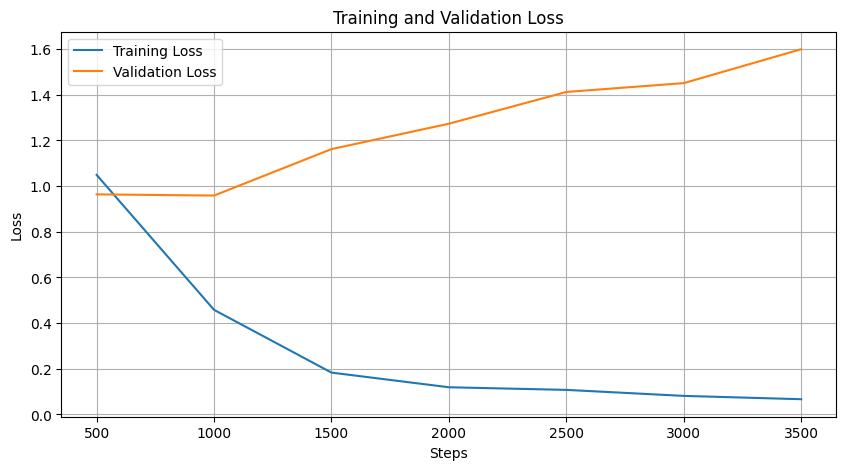

In [46]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

def plot_training_loss(log_dir):
    event_files = [os.path.join(log_dir, f) for f in os.listdir(log_dir) if 'events' in f]
    if not event_files:
        raise ValueError("No event files found in log directory.")

    for event_file in event_files:
        losses = {'Step': [], 'Training Loss': [], 'Validation Loss': []}
        for e in tf.compat.v1.train.summary_iterator(event_file):
            for v in e.summary.value:
                if v.tag == 'train/loss':
                    losses['Training Loss'].append(v.simple_value)
                    losses['Step'].append(e.step)
                elif v.tag == 'eval/loss':
                    losses['Validation Loss'].append(v.simple_value)

        if losses['Step']:
            df = pd.DataFrame(losses).set_index('Step')
            plt.figure(figsize=(10, 5))
            plt.plot(df['Training Loss'], label='Training Loss')
            plt.plot(df['Validation Loss'], label='Validation Loss')
            plt.xlabel('Steps')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

# 로그 디렉토리를 지정하여 그래프 그리기
plot_training_loss('./logs')

In [47]:
test_dataset = encoded_dataset['test']

In [48]:
# 평가 데이터셋에 대한 예측 수행
predictions = trainer.predict(test_dataset)

In [49]:
# 예측된 레이블과 실제 레이블 추출
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# 각 클래스별 F1 스코어 계산
class_f1_scores = f1_score(true_labels, predicted_labels, average=None)

# 클래스별 F1 스코어 출력
for class_id, f1_score_value in enumerate(class_f1_scores):
    print(f"Class {class_id} F1 Score: {f1_score_value}")

Class 0 F1 Score: 0.7072633895818049
Class 1 F1 Score: 0.6915662650602409
Class 2 F1 Score: 0.9550000000000001
Class 3 F1 Score: 0.7482419127988749
Class 4 F1 Score: 0.6915351506456241
Class 5 F1 Score: 0.7663280116110304
Class 6 F1 Score: 0.7455621301775147
Class 7 F1 Score: 0.788135593220339
Class 8 F1 Score: 0.6652267818574514


In [50]:
trainer.save_model('/content/drive/MyDrive/models/CCIT_graphcodebert_N:N(feature)(05-20)')

In [51]:
import pandas as pd

df2 = pd.read_csv("/content/drive/MyDrive/data/MSR+julite+Div_final_test(2500cut).csv")

In [52]:
df2.head(50)

,CWE ID,vul,lang,code,labels
0,CWE-119,1,c,"enum void func( const char *name, struct group...",0
1,CWE-119,1,c,"void func(struct sshbuf *m, struct ssh *ssh, i...",0
2,CWE-119,1,c,"void func(Jbig2HuffmanState *hs, int offset) {...",0
3,CWE-119,1,c,"void func(struct file *file, unsigned long add...",0
4,CWE-119,1,c,"void func(StyleDifference diff, const RenderSt...",0
5,CWE-119,1,c,long long Chapters::Atom::GetStartTimecode() c...,0
6,CWE-119,1,c,void func(struct atusb *atusb) { struct usb_d...,0
7,CWE-119,1,c,"void func(TGAContext *ctx, GError **err) { TGA...",0
8,CWE-119,1,c,void func( FT_Error error_code ) { FT_Face fa...,0
9,CWE-119,1,c,"void func( const ExtensionIdSet* extensions, i...",0


In [53]:
df2 = df2[['vul', 'code']]

In [54]:
import re

def preprocess2(df2, file_name):
    # 멀티 라인 주석 제거
    df2['code'] = df2['code'].replace(re.compile(r'/\*.*?\*/', re.DOTALL), "", regex=True)
    # 싱글 라인 주석 제거
    df2['code'] = df2['code'].replace(re.compile(r'//.*?\n'), "", regex=True)
    # angle brackets를 사용하는 include 제거
    df2['code'] = df2['code'].replace(re.compile(r'#include .*?\n'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#include "*.*?\n'), "", regex=True)
    # 매크로 정의 제거
    df2['code'] = df2['code'].replace(re.compile(r'#define .*?\n'), "", regex=True)
    # 전처리 지시문 제거
    df2['code'] = df2['code'].replace(re.compile(r'#undef\s+\w+'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#if\s+\w+'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#else\s+\w+'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#elif\s+\w+'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#endif'), "", regex=True)
    # 탭과 여러 공백을 하나의 공백으로
    df2['code'] = df2['code'].replace(re.compile(r'[\t ]+'), " ", regex=True)
    # 여러 줄바꿈을 하나로
    df2['code'] = df2['code'].replace(re.compile(r'\n\s*\n'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'\n'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'return*.*?;'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'return;'), "", regex=True)
    # void func 로 변경
    df2['code'] = df2['code'].replace(re.compile(r'\b([a-zA-Z_]\w*)\s+([a-zA-Z_]\w*)\s*\(([^)]*)\)\s*{'), r"void func(\3){", regex=True)
    # 데이터프레임을 CSV 파일로 저장
    df2.to_csv(file_name, index=False)
    return df2  # 수정된 데이터프레임 반환


def tokenized(examples):
  return tokenizer(examples['code'], pad_to_max_length=True, max_length=MAX_LEN,truncation=True, return_token_type_ids=True)

In [55]:
preprocess2(df2,"preprocess2.csv")
dataset = load_dataset("csv",data_files="preprocess2.csv")['train']
encoded_dataset2 = dataset.map(tokenized,remove_columns=['code'],batched=True)
encoded_dataset2=encoded_dataset2.rename_column(original_column_name='vul',new_column_name='labels')

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/225 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [56]:
trainer.predict(encoded_dataset2, metric_key_prefix="eval")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PredictionOutput(predictions=array([[ 4.660657  , -2.5705369 ,  0.11959469, ..., -1.3355134 ,
         1.689577  , -1.9967346 ],
       [ 6.5797296 , -0.95388   , -1.8824875 , ..., -0.57528645,
         0.3256358 , -2.6369462 ],
       [ 4.345282  , -0.58350223, -2.8403087 , ..., -1.9719067 ,
         1.0668843 , -0.63878554],
       ...,
       [ 0.9006021 ,  0.13993444, -1.5811958 , ..., -2.5514946 ,
         3.5459676 , -3.3546348 ],
       [-0.49093464, -1.0063568 , -0.49914032, ..., -1.2310026 ,
        -0.22677183, -2.1919858 ],
       [ 0.47321862, -2.5041473 , -0.7619844 , ..., -2.5141613 ,
        -0.22338876, -1.5975523 ]], dtype=float32), label_ids=array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 